# CAPTCHA Pipeline (Seq2Seq + Attention + Beam Search)

## 1. Environment Setting


In [1]:
# 1.

import cv2, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import models
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

CHARS = "0123456789abcdefghijklmnopqrstuvwxyz"
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2

# charset → id
id2ch = ["<pad>", "<sos>", "<eos>"] + list(CHARS)
ch2id = {ch: i for i, ch in enumerate(id2ch)}

VOCAB_SIZE = len(id2ch)
print("vocab size:", VOCAB_SIZE)

# Parameters
MODEL_H = 80           # images resize height
ENCODER_HIDDEN = 256   # Encoder input
DECODER_HIDDEN = 256   # Decoder hidden layer
EMBED_DIM = 128
ATTN_DIM = 128
MODEL_DROPOUT = 0.1


device: cuda
vocab size: 39


In [2]:
import os

TRAIN_ROOT = "data/processed/train"
TEST_ROOT  = "data/processed/test"

train_img_files = [
    os.path.join(TRAIN_ROOT, f)
    for f in os.listdir(TRAIN_ROOT)
    if f.lower().endswith(".png")
]

test_img_files = [
    os.path.join(TEST_ROOT, f)
    for f in os.listdir(TEST_ROOT)
    if f.lower().endswith(".png")
]

print("train images:", len(train_img_files))
print("test  images:", len(test_img_files))

train_labels = {}
for p in train_img_files:
    name = os.path.splitext(os.path.basename(p))[0]   # e.g. "0azxq-0"
    label_name = name.split('-')[0]
    if label_name not in train_labels:
        train_labels[label_name] = label_name
    else: 
        print(label_name)

test_labels = {}
for p in test_img_files:
    name = os.path.splitext(os.path.basename(p))[0]
    label_name = name.split('-')[0]
    test_labels[label_name] = label_name

print("train label entries:", len(train_labels))
print("test  label entries:", len(test_labels))


train images: 7818
test  images: 2000
train label entries: 7818
test  label entries: 2000


## 2. Image preprocessing module: 

In [3]:
import cv2
import numpy as np

def load_captcha_png(path, target_h=80):
    img = cv2.imdecode(np.fromfile(path, np.uint8), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise RuntimeError(f"cannot read {path}")

    # RGBA → White background
    if img.ndim == 3 and img.shape[2] == 4:
        b, g, r, a = cv2.split(img)
        a = a.astype(np.float32) / 255.0
        white = np.ones_like(b, dtype=np.float32) * 255
        b = b.astype(np.float32) * a + white * (1 - a)
        g = g.astype(np.float32) * a + white * (1 - a)
        r = r.astype(np.float32) * a + white * (1 - a)
        img = cv2.merge([b.astype(np.uint8), g.astype(np.uint8), r.astype(np.uint8)])

    # Make sure BGR
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    h, w = img.shape[:2]
    if h != target_h:
        scale = target_h / h
        new_w = int(w * scale)
        img = cv2.resize(img, (new_w, target_h), interpolation=cv2.INTER_LINEAR)

    return img    # BGR, White background


def crop_lr_on_white(bgr, thr=250, margin=4, min_w=20):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray, alpha=1.3, beta=0)
    h, w = gray.shape
    col_max = gray.max(axis=0)           # (w,)
    not_white = col_max < thr            # True means not blank

    if not not_white.any():
        return bgr

    left = np.argmax(not_white)
    right = w - 1 - np.argmax(not_white[::-1])

    left = max(0, left - margin)
    right = min(w - 1, right + margin)

    if right - left + 1 < min_w:
        right = min(left + min_w, w - 1)

    return bgr[:, left:right+1, :]


def preprocess_captcha_white(path, target_h=80):
    bgr = load_captcha_png(path, target_h=target_h)
    bgr = crop_lr_on_white(bgr)              # (80, W', 3)
    # BGR → RGB → [0,1]
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    img = rgb.astype(np.float32) / 255.0     # (80, W', 3) White=1.0
    return img


## 4. Dataset and Collate

In [4]:
class SortedWidthBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.batch_size = batch_size
        widths = []
        for i in range(len(dataset)):
            p = dataset.paths[i]
            img = cv2.imdecode(np.fromfile(p, np.uint8), cv2.IMREAD_UNCHANGED)
            h, w = img.shape[:2]
            widths.append((w, i))
        # increasing order
        widths.sort(key=lambda x: x[0])
        self.indices = [idx for _, idx in widths]

    def __iter__(self):
        # shaffle a bit
        batches = [
            self.indices[i:i+self.batch_size]
            for i in range(0, len(self.indices), self.batch_size)
        ]
        np.random.shuffle(batches)
        for b in batches:
            yield b

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

In [5]:
# 4. Dataset & collate

class CaptchaDataset(Dataset):
    def __init__(self, img_paths, labels_dict, charset_map, h=80):
        self.paths = img_paths
        self.labels = labels_dict
        self.charset = charset_map
        self.H = h

    def encode_text(self, text: str):
        ids = [SOS_TOKEN]
        for ch in text:
            if ch in self.charset:
                ids.append(self.charset[ch])
        ids.append(EOS_TOKEN)
        return np.array(ids, dtype=np.int64)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = preprocess_captcha_white(p, target_h=self.H)   # (H, W, 3)

        # get tag
        name = os.path.splitext(os.path.basename(p))[0]
        label_name = name.split('-')[0]
        text = self.labels.get(label_name, label_name)
        tgt = self.encode_text(text)

        return img, tgt, text, p



import torch

def seq2seq_collate_fn(batch, pad_value=1.0):   # white→1.0
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.zeros(1,3,MODEL_H,MODEL_H), torch.tensor([[PAD_TOKEN]]), [""], [""]

    imgs   = [torch.from_numpy(b[0]).permute(2,0,1) for b in batch]  # (3,H,W)
    tgts   = [torch.from_numpy(b[1]) for b in batch]
    texts  = [b[2] for b in batch]
    paths  = [b[3] for b in batch]

    B = len(imgs)
    C, H = imgs[0].shape[0], imgs[0].shape[1]
    widths = [im.shape[2] for im in imgs]
    maxW = max(widths)

    # (B,3,H,maxW) All white first
    imgs_pad = torch.full((B, C, H, maxW), pad_value, dtype=torch.float32)
    for i, im in enumerate(imgs):
        _, _, w = im.shape
        # in middle
        pad_left = (maxW - w) // 2
        imgs_pad[i, :, :, pad_left:pad_left + w] = im

    # pad label
    maxL = max(t.size(0) for t in tgts)
    tgts_pad = torch.full((B, maxL), PAD_TOKEN, dtype=torch.long)
    for i, t in enumerate(tgts):
        L = t.size(0)
        tgts_pad[i, :L] = t

    return imgs_pad, tgts_pad, texts, paths


# Construct Dataset
train_ds = CaptchaDataset(train_img_files, train_labels, ch2id, h=MODEL_H)
test_ds  = CaptchaDataset(test_img_files,  test_labels,  ch2id, h=MODEL_H)

# Construct DataLoader
BATCH_SIZE = 8

train_dl = DataLoader(
    train_ds,
    batch_sampler=SortedWidthBatchSampler(train_ds, BATCH_SIZE),
    collate_fn=seq2seq_collate_fn,
    num_workers=0,
)

test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=seq2seq_collate_fn,
    num_workers=0,
)

print("train batches:", len(train_dl))
print("test  batches:", len(test_dl))


train batches: 978
test  batches: 250


### 4.1 visualization

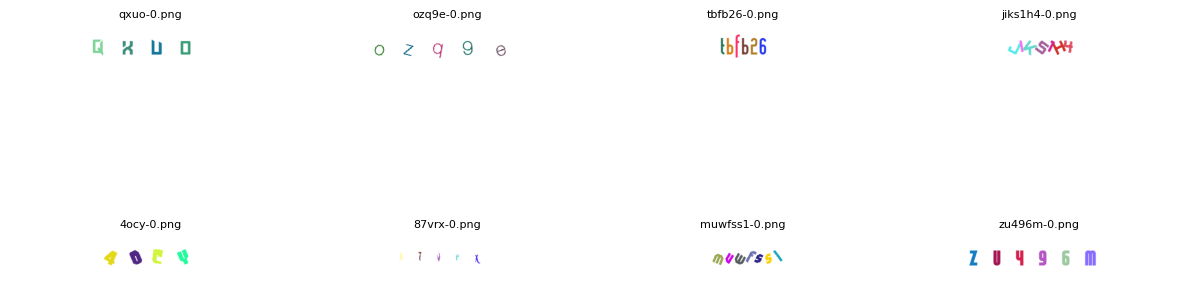

batch shape: torch.Size([8, 3, 80, 575]) min: 0.019607843831181526 max: 1.0
texts: ['qxuo', 'ozq9e', 'tbfb26', 'jiks1h4', '4ocy']


In [6]:
# 5.

train_ds = CaptchaDataset(train_img_files, train_labels, ch2id, h=MODEL_H)
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=seq2seq_collate_fn,
    num_workers=0,
)


images_batch, labels_batch, texts_batch, paths_batch = next(iter(train_dl))

def show_batch(images_tensor, paths, max_cols=4):
    B, C, H, W = images_tensor.shape
    cols = min(max_cols, B)
    rows = math.ceil(B / cols)
    plt.figure(figsize=(3*cols, 3*rows))
    for i in range(B):
        plt.subplot(rows, cols, i+1)

        img = images_tensor[i].cpu().numpy()  # (C,H,W)
        if img.shape[0] == 1:
            img = img[0]
            plt.imshow(img, cmap='gray')
        else:
            img = np.transpose(img, (1, 2, 0))
            plt.imshow(img)
        plt.title(os.path.basename(paths[i]), fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


show_batch(images_batch, paths_batch)

print("batch shape:", images_batch.shape,
      "min:", images_batch.min().item(),
      "max:", images_batch.max().item())

print("texts:", texts_batch[:5])


## 5. Model：ResNet → LSTM → Decoder（with attention）

### 5.1 ResNet

In [7]:
class ResNetBackbone(nn.Module):
    def __init__(self, stage="layer3", pretrained=True):
        super().__init__()
        m = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        )

        self.stem = nn.Sequential(
            m.conv1,
            m.bn1,
            m.relu,
            m.maxpool,
            m.layer1,
            m.layer2,
        )

        if stage == "layer3":
            self.body = m.layer3
            self.out_channels = 256
        else:
            self.body = nn.Sequential(m.layer3, m.layer4)
            self.out_channels = 512

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        x = self.stem(x)
        x = self.body(x)
        return x

### 5.2 Feature -> seq + LSTM

In [8]:
class ResnetBiLSTMEncoder(nn.Module):
    def __init__(
        self,
        encoder_hidden,
        resnet_stage="layer3",
        pretrained=True,
        lstm_hidden=None,
        lstm_layers=1,
        dropout=0.1,
        input_height=80,
    ):
        super().__init__()
        self.backbone = ResNetBackbone(stage=resnet_stage, pretrained=pretrained)
        C = self.backbone.out_channels
        feat_h = input_height // 16     # 80 -> 5
        self.feat_h = feat_h

        if lstm_hidden is None:
            lstm_hidden = encoder_hidden

        in_feat_dim = C * feat_h        # 256 * 5 = 1280

        # CNN → Linear
        self.feat_proj = nn.Linear(in_feat_dim, encoder_hidden)
        self.feat_norm = nn.LayerNorm(encoder_hidden)

        self.lstm = nn.LSTM(
            input_size=encoder_hidden,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0.0,
        )

        self.seq_proj = nn.Sequential(
            nn.Linear(2 * lstm_hidden, encoder_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.h_proj = nn.Linear(2 * lstm_hidden, encoder_hidden)

    def forward(self, images):
        # images: (B,1,H,W)
        feat = self.backbone(images)         # (B,C,H',W')
        B, C, H, W = feat.size()

        # → (B, W, C*H')
        feat = feat.permute(0, 3, 1, 2).reshape(B, W, C * H)
        feat = self.feat_proj(feat)          # (B, W, enc_h)
        feat = self.feat_norm(feat)          # (B, W, enc_h)
        feat = feat.permute(1, 0, 2)         # (T, B, enc_h)

        lstm_out, (h, c) = self.lstm(feat)   # lstm_out: (T, B, 2*lstm_h)

        enc_out = self.seq_proj(lstm_out)    # (T, B, enc_h)

        # Global state
        h_fwd = h[-2]                        # (B, lstm_h)
        h_bwd = h[-1]                        # (B, lstm_h)
        h_cat = torch.cat([h_fwd, h_bwd], dim=1)  # (B, 2*lstm_h)
        enc_final = self.h_proj(h_cat)            # (B, enc_h)

        return enc_out, enc_final


### 5.3 Attention

In [9]:
class AdditiveAttention(nn.Module):
    def __init__(self, enc_h, dec_h, attn_dim):
        super().__init__()
        self.W_h = nn.Linear(enc_h, attn_dim, bias=False)
        self.W_s = nn.Linear(dec_h, attn_dim, bias=False)
        self.v   = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, enc_out, dec_state, mask=None):
        # enc_out: (T, B, H)
        # dec_state: (B, dec_h)
        T, B, H = enc_out.size()

        enc_proj = self.W_h(enc_out)                          # (T,B,A)
        dec_proj = self.W_s(dec_state).unsqueeze(0).expand(T, B, -1)
        e = torch.tanh(enc_proj + dec_proj)                   # (T,B,A)
        e = self.v(e).squeeze(-1).permute(1, 0)               # (B,T)

        if mask is not None:
            e = e.masked_fill(mask == 0, -1e9)

        alpha = torch.softmax(e, dim=1)

        # enc_out: (T,B,H) → (B,T,H)
        enc_out_bt = enc_out.permute(1, 0, 2)
        ctx = torch.bmm(alpha.unsqueeze(1), enc_out_bt).squeeze(1)  # (B,H)

        return ctx, alpha


### 5.4 Decoder 

In [10]:
class AttnDecoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        encoder_hidden,
        decoder_hidden,
        attn_dim,
        dropout_p=0.1,
        sos_token_id=SOS_TOKEN,
        num_layers=2,
    ):
        super().__init__()
        self.sos_token_id = sos_token_id
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.attn  = AdditiveAttention(encoder_hidden, decoder_hidden, attn_dim)

        self.rnn = nn.LSTM(
            input_size=encoder_hidden + embed_dim,
            hidden_size=decoder_hidden,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout_p if num_layers > 1 else 0.0,
        )

        self.fc_out = nn.Linear(decoder_hidden, vocab_size)
        self.dropout = nn.Dropout(dropout_p)
        self.decoder_hidden = decoder_hidden
        self.num_layers = num_layers

    def forward(self, enc_out, enc_final, targets=None, teacher_forcing_ratio=0.5):
        """
        enc_out:  (T, B, H_enc)
        enc_final:(B, H_enc)
        targets:  (B, L) include <sos> ... <eos> <pad> ...
        """
        T, B, H_enc = enc_out.size()

        if targets is not None:
            tgt_mask = (targets != PAD_TOKEN)
            tgt_lens = tgt_mask.sum(dim=1)
            max_len = int(tgt_lens.max().item()) - 1
        else:
            max_len = 50

        h0 = enc_final.unsqueeze(0).repeat(self.num_layers, 1, 1)  # (num_layers,B,H_dec)
        c0 = torch.zeros_like(h0)
        hidden = (h0, c0)

        dec_input = torch.full((B,), self.sos_token_id, dtype=torch.long, device=enc_out.device)

        outputs = []

        for t in range(max_len):
            gold_next = None
            if targets is not None and (t + 1) < targets.size(1):
                gold_next = targets[:, t+1]    # (B,)

            # 1) attention
            context, _ = self.attn(enc_out, hidden[0][-1])   # (B, H_enc)

            # 2) embedding
            emb = self.embed(dec_input)                      # (B, E)

            # 3) LSTM
            rnn_in = torch.cat([context, emb], dim=1).unsqueeze(0)  # (1,B,H_enc+E)
            out, hidden = self.rnn(rnn_in, hidden)                  # out: (1,B,H_dec)

            # 4) projection to vocab
            logits_t = self.fc_out(out.squeeze(0))                  # (B, vocab)
            outputs.append(logits_t.unsqueeze(1))

            # 5) Decide next input
            next_input = logits_t.argmax(dim=1)

            if gold_next is not None:
                valid_pos = (gold_next != PAD_TOKEN).long()          # (B,)
                if teacher_forcing_ratio > 0.0:
                    if torch.rand(1).item() < teacher_forcing_ratio:
                        next_input = torch.where(valid_pos.bool(), gold_next, next_input)

            dec_input = next_input

        outputs = torch.cat(outputs, dim=1)  # (B, max_len, vocab)
        return outputs


### 5.5 Seq2Seq

In [11]:
class ResnetLSTMSeq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_dim,
                 encoder_hidden, decoder_hidden,
                 attn_dim, sos_token_id, device,
                 pretrained_backbone=True):
        super().__init__()
        self.encoder = ResnetBiLSTMEncoder(
            encoder_hidden=encoder_hidden,
            resnet_stage="layer3",
            pretrained=pretrained_backbone,
            lstm_hidden=encoder_hidden,
            lstm_layers=1,
            dropout=0.1,
            input_height=MODEL_H,
        )
        self.decoder = AttnDecoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            encoder_hidden=encoder_hidden,
            decoder_hidden=decoder_hidden,
            attn_dim=attn_dim,
            dropout_p=0.1,
            sos_token_id=sos_token_id,
            num_layers=2,              
        )
        self.device = device

    def forward(self, images, targets=None, teacher_forcing_ratio=0.5):
        enc_out, enc_final = self.encoder(images)
        logits = self.decoder(enc_out, enc_final, targets, teacher_forcing_ratio)
        return logits


## 6. Loss function

In [12]:
def calculate_loss(logits, targets, criterion):
    B, L_dec, V = logits.size()

    targets_trimmed = targets[:, 1:1 + L_dec]

    # Flat
    logits_flat = logits.reshape(B * L_dec, V)
    targets_flat = targets_trimmed.reshape(B * L_dec)

    loss = criterion(logits_flat, targets_flat)
    return loss


## 9. Predict：Beam Search

In [13]:
def decoder_step_lstm(decoder, enc_out, prev_token, prev_hidden):
    """
    enc_out: (T, 1, H_enc)
    prev_token: (1,)
    prev_hidden: (h, c) -> (L,1,H_dec)
    """
    h, c = prev_hidden
    context, _ = decoder.attn(enc_out, h[-1])              # (1, H_enc)
    emb = decoder.embed(prev_token)                        # (1, E)
    rnn_in = torch.cat([context, emb], dim=1).unsqueeze(0) # (1,1,H_enc+E)
    out, (h_new, c_new) = decoder.rnn(rnn_in, (h, c))      # out: (1,1,H_dec)
    logits = decoder.fc_out(out.squeeze(0))                # (1, vocab)
    return logits, (h_new, c_new)


def predict_batch_beam_search(model, images_batch, beam_width=5, max_len=50):
    """
    beam search decode
    return: (list_of_token_seqs, list_of_texts)
    """
    model.eval()
    device = next(model.parameters()).device
    images_batch = images_batch.to(device)
    B = images_batch.size(0)

    batch_token_seqs = []
    batch_texts = []

    with torch.no_grad():
        # encoder
        enc_out_all, enc_final_all = model.encoder(images_batch)   # enc_out: (T,B,H), enc_final: (B,H)

        for b in range(B):
            enc_out_b = enc_out_all[:, b:b+1, :]   # (T,1,H_enc)
            enc_final_b = enc_final_all[b:b+1, :]  # (1,H_enc)

            # init hidden
            num_layers = model.decoder.num_layers
            h0 = enc_final_b.unsqueeze(0).repeat(num_layers, 1, 1)  # (L,1,H_dec)
            c0 = torch.zeros_like(h0)
            start_hidden = (h0, c0)

            # init beam：only <sos>
            start_seq = torch.tensor([SOS_TOKEN], dtype=torch.long, device=device)  # (1,)
            beams = [(start_seq, 0.0, start_hidden)]   # (seq, logprob, hidden)
            completed = []

            for _ in range(max_len):
                new_beams = []

                for seq, score, hidden in beams:
                    last_token = seq[-1].unsqueeze(0)  # (1,)

                    if last_token.item() == EOS_TOKEN:
                        completed.append((seq, score, hidden))
                        continue

                    # decoder
                    logits, new_hidden = decoder_step_lstm(model.decoder, enc_out_b, last_token, hidden)
                    log_probs = F.log_softmax(logits, dim=1)           # (1, vocab)
                    topk_log_probs, topk_idx = log_probs.topk(beam_width, dim=1)

                    for k in range(beam_width):
                        tok = topk_idx[0, k].unsqueeze(0)               # (1,)
                        h_k = new_hidden[0].clone()
                        c_k = new_hidden[1].clone()
                        new_seq = torch.cat([seq, tok], dim=0)          # (len+1,)
                        new_score = score + topk_log_probs[0, k].item()
                        new_beams.append((new_seq, new_score, (h_k, c_k)))

                if not new_beams:
                    break

                new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)
                beams = new_beams[:beam_width]

                if all(bm[0][-1].item() == EOS_TOKEN for bm in beams):
                    completed.extend(beams)
                    break

            if not completed:
                completed = beams

            best = sorted(completed, key=lambda x: x[1], reverse=True)[0]
            best_tokens = best[0].tolist()
            batch_token_seqs.append(best_tokens)

    # token → text
    for tokens in batch_token_seqs:
        text = "".join(
            id2ch[t]
            for t in tokens
            if t not in (PAD_TOKEN, SOS_TOKEN, EOS_TOKEN) and t < len(id2ch)
        )
        batch_texts.append(text)

    return batch_token_seqs, batch_texts


## 7. Training loop（100 epochs）

In [14]:
# ============================================================
# 7. train
# ============================================================

NUM_EPOCHS = 100
BASE_LR    = 3e-4
BATCH_SIZE = 32

# dataset / dataloader
train_ds = CaptchaDataset(train_img_files, train_labels, ch2id, h=MODEL_H)
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=seq2seq_collate_fn,
    num_workers=0,
)

# init model
model = ResnetLSTMSeq2Seq(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    encoder_hidden=ENCODER_HIDDEN,
    decoder_hidden=DECODER_HIDDEN,
    attn_dim=ATTN_DIM,
    sos_token_id=SOS_TOKEN,
    device=device,
    pretrained_backbone=True,
).to(device)

encoder_params = list(model.encoder.parameters())
decoder_params = list(model.decoder.parameters())

criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN).to(device)
optimizer = torch.optim.Adam([
    {"params": encoder_params, "lr": 1e-4},   # encoder/backbone
    {"params": decoder_params, "lr": 1e-3},   # decoder
])

In [15]:
# ============================================================
# ============================================================
def quick_eval_characc(model, loader, max_batches=200):
    model.eval()
    char_accs = []
    with torch.no_grad():
        for bi, (imgs, _, texts, _) in enumerate(loader):
            imgs = imgs.to(device)
            logits = model(imgs, None, teacher_forcing_ratio=0.0)
            preds = logits.argmax(dim=2)
            for gt, pr in zip(texts, preds):
                pr_text = ""
                for id_ in pr.cpu().tolist():
                    if id_ == EOS_TOKEN:
                        break
                    if id_ >= len(id2ch):
                        continue
                    ch = id2ch[id_]
                    if ch not in ("<pad>", "<sos>", "<eos>"):
                        pr_text += ch
                if len(gt) == 0:
                    continue
                same = sum(1 for a, b in zip(gt, pr_text) if a == b)
                char_accs.append(same / len(gt))
            if bi >= max_batches:
                break
    return sum(char_accs) / len(char_accs) if char_accs else 0.0

Start training on 7818 images ...


Epoch 1/100 (lr_enc=1.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:18<00:00, 13.44it/s, loss=3.23]


--- Epoch 1 done, avg loss: 3.2939, backbone training: False ---


Epoch 2/100 (lr_enc=1.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:16<00:00, 15.04it/s, loss=3.21]


--- Epoch 2 done, avg loss: 3.2114, backbone training: False ---


Epoch 3/100 (lr_enc=1.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:23<00:00, 10.30it/s, loss=3.15]


--- Epoch 3 done, avg loss: 3.1830, backbone training: True ---


Epoch 4/100 (lr_enc=1.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:23<00:00, 10.60it/s, loss=3.12]


--- Epoch 4 done, avg loss: 3.1359, backbone training: True ---


Epoch 5/100 (lr_enc=1.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.68it/s, loss=3.12]


--- Epoch 5 done, avg loss: 3.1096, backbone training: True ---
 Eval after epoch 5: seq-acc=0.0000, char-acc=0.0258
 New best saved: seq-acc=0.0000, char-acc=0.0258


Epoch 6/100 (lr_enc=1.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:23<00:00, 10.44it/s, loss=3.12]


--- Epoch 6 done, avg loss: 3.0976, backbone training: True ---


Epoch 7/100 (lr_enc=1.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:23<00:00, 10.60it/s, loss=3.07]


--- Epoch 7 done, avg loss: 3.0883, backbone training: True ---


Epoch 8/100 (lr_enc=1.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.70it/s, loss=3.09]


--- Epoch 8 done, avg loss: 3.0783, backbone training: True ---


Epoch 9/100 (lr_enc=1.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.89it/s, loss=3.06]


--- Epoch 9 done, avg loss: 3.0643, backbone training: True ---


Epoch 10/100 (lr_enc=1.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.80it/s, loss=3.05]


--- Epoch 10 done, avg loss: 3.0429, backbone training: True ---
 Eval after epoch 10: seq-acc=0.0000, char-acc=0.0295
 New best saved: seq-acc=0.0000, char-acc=0.0295
↑ bump enc lr to 3e-4 at epoch 10


Epoch 11/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.78it/s, loss=3.01]


--- Epoch 11 done, avg loss: 3.0446, backbone training: True ---


Epoch 12/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.67it/s, loss=3.01]


--- Epoch 12 done, avg loss: 2.9934, backbone training: True ---


Epoch 13/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.66it/s, loss=2.99]


--- Epoch 13 done, avg loss: 2.9520, backbone training: True ---


Epoch 14/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:23<00:00, 10.41it/s, loss=2.89]


--- Epoch 14 done, avg loss: 2.8906, backbone training: True ---


Epoch 15/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:23<00:00, 10.59it/s, loss=2.83]


--- Epoch 15 done, avg loss: 2.8357, backbone training: True ---
 Eval after epoch 15: seq-acc=0.0000, char-acc=0.0309
 New best saved: seq-acc=0.0000, char-acc=0.0309


Epoch 16/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.88it/s, loss=2.75]


--- Epoch 16 done, avg loss: 2.7204, backbone training: True ---


Epoch 17/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 11.03it/s, loss=2.56]


--- Epoch 17 done, avg loss: 2.5730, backbone training: True ---


Epoch 18/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.90it/s, loss=2.36]


--- Epoch 18 done, avg loss: 2.3962, backbone training: True ---


Epoch 19/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 11.00it/s, loss=2.15]


--- Epoch 19 done, avg loss: 2.1563, backbone training: True ---


Epoch 20/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 11.01it/s, loss=1.88]


--- Epoch 20 done, avg loss: 1.9319, backbone training: True ---
 Eval after epoch 20: seq-acc=0.0000, char-acc=0.0871
 New best saved: seq-acc=0.0000, char-acc=0.0871


Epoch 21/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:23<00:00, 10.51it/s, loss=1.77]


--- Epoch 21 done, avg loss: 1.7549, backbone training: True ---


Epoch 22/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:25<00:00,  9.69it/s, loss=1.56]


--- Epoch 22 done, avg loss: 1.5794, backbone training: True ---


Epoch 23/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:23<00:00, 10.64it/s, loss=1.5] 


--- Epoch 23 done, avg loss: 1.4388, backbone training: True ---


Epoch 24/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.89it/s, loss=1.36]


--- Epoch 24 done, avg loss: 1.3088, backbone training: True ---


Epoch 25/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.69it/s, loss=1.12]


--- Epoch 25 done, avg loss: 1.1651, backbone training: True ---
 Eval after epoch 25: seq-acc=0.0005, char-acc=0.1712
 New best saved: seq-acc=0.0005, char-acc=0.1712


Epoch 26/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:23<00:00, 10.64it/s, loss=1.02] 


--- Epoch 26 done, avg loss: 1.0308, backbone training: True ---


Epoch 27/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.93it/s, loss=1.01] 


--- Epoch 27 done, avg loss: 0.9294, backbone training: True ---


Epoch 28/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.72it/s, loss=0.833]


--- Epoch 28 done, avg loss: 0.8400, backbone training: True ---


Epoch 29/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.85it/s, loss=0.737]


--- Epoch 29 done, avg loss: 0.7458, backbone training: True ---


Epoch 30/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=1.00): 100%|██████████| 245/245 [00:22<00:00, 10.88it/s, loss=0.679]


--- Epoch 30 done, avg loss: 0.6899, backbone training: True ---
 Eval after epoch 30: seq-acc=0.0060, char-acc=0.3137
 New best saved: seq-acc=0.0060, char-acc=0.3137


Epoch 31/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.94it/s, loss=0.988]


--- Epoch 31 done, avg loss: 0.9592, backbone training: True ---


Epoch 32/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 11.13it/s, loss=0.772]


--- Epoch 32 done, avg loss: 0.8548, backbone training: True ---


Epoch 33/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.94it/s, loss=0.759]


--- Epoch 33 done, avg loss: 0.7328, backbone training: True ---


Epoch 34/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:23<00:00, 10.33it/s, loss=0.674]


--- Epoch 34 done, avg loss: 0.6771, backbone training: True ---


Epoch 35/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:23<00:00, 10.34it/s, loss=0.522]


--- Epoch 35 done, avg loss: 0.5757, backbone training: True ---
 Eval after epoch 35: seq-acc=0.0370, char-acc=0.5091
 New best saved: seq-acc=0.0370, char-acc=0.5091


Epoch 36/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:23<00:00, 10.64it/s, loss=0.492]


--- Epoch 36 done, avg loss: 0.5165, backbone training: True ---


Epoch 37/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.98it/s, loss=0.463]


--- Epoch 37 done, avg loss: 0.4665, backbone training: True ---


Epoch 38/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 11.06it/s, loss=0.412]


--- Epoch 38 done, avg loss: 0.4115, backbone training: True ---


Epoch 39/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 11.11it/s, loss=0.449]


--- Epoch 39 done, avg loss: 0.3751, backbone training: True ---


Epoch 40/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 11.04it/s, loss=0.386]


--- Epoch 40 done, avg loss: 0.3644, backbone training: True ---
 Eval after epoch 40: seq-acc=0.0035, char-acc=0.1473


Epoch 41/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.88it/s, loss=0.283]


--- Epoch 41 done, avg loss: 0.2962, backbone training: True ---


Epoch 42/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.80it/s, loss=0.288]


--- Epoch 42 done, avg loss: 0.2785, backbone training: True ---


Epoch 43/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.81it/s, loss=0.27] 


--- Epoch 43 done, avg loss: 0.2565, backbone training: True ---


Epoch 44/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.71it/s, loss=0.251]


--- Epoch 44 done, avg loss: 0.2429, backbone training: True ---


Epoch 45/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.78it/s, loss=0.242]


--- Epoch 45 done, avg loss: 0.2238, backbone training: True ---
 Eval after epoch 45: seq-acc=0.1420, char-acc=0.6461
 New best saved: seq-acc=0.1420, char-acc=0.6461


Epoch 46/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.66it/s, loss=0.293]


--- Epoch 46 done, avg loss: 0.2375, backbone training: True ---


Epoch 47/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:23<00:00, 10.37it/s, loss=0.255]


--- Epoch 47 done, avg loss: 0.2011, backbone training: True ---


Epoch 48/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:24<00:00, 10.11it/s, loss=0.23] 


--- Epoch 48 done, avg loss: 0.1835, backbone training: True ---


Epoch 49/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:23<00:00, 10.41it/s, loss=0.171]


--- Epoch 49 done, avg loss: 0.1664, backbone training: True ---


Epoch 50/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:23<00:00, 10.55it/s, loss=0.204]


--- Epoch 50 done, avg loss: 0.1814, backbone training: True ---
 Eval after epoch 50: seq-acc=0.1555, char-acc=0.6531
 New best saved: seq-acc=0.1555, char-acc=0.6531


Epoch 51/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:23<00:00, 10.33it/s, loss=0.155]


--- Epoch 51 done, avg loss: 0.1789, backbone training: True ---


Epoch 52/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:23<00:00, 10.36it/s, loss=0.17] 


--- Epoch 52 done, avg loss: 0.1451, backbone training: True ---


Epoch 53/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:23<00:00, 10.59it/s, loss=0.168]


--- Epoch 53 done, avg loss: 0.1419, backbone training: True ---


Epoch 54/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:23<00:00, 10.65it/s, loss=0.164]


--- Epoch 54 done, avg loss: 0.1504, backbone training: True ---


Epoch 55/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.71it/s, loss=0.12] 


--- Epoch 55 done, avg loss: 0.1342, backbone training: True ---
 Eval after epoch 55: seq-acc=0.2320, char-acc=0.7198
 New best saved: seq-acc=0.2320, char-acc=0.7198


Epoch 56/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.90it/s, loss=0.112]


--- Epoch 56 done, avg loss: 0.1164, backbone training: True ---


Epoch 57/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 11.04it/s, loss=0.129] 


--- Epoch 57 done, avg loss: 0.1185, backbone training: True ---


Epoch 58/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.99it/s, loss=0.113] 


--- Epoch 58 done, avg loss: 0.1148, backbone training: True ---


Epoch 59/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.91it/s, loss=0.122] 


--- Epoch 59 done, avg loss: 0.0988, backbone training: True ---


Epoch 60/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.70): 100%|██████████| 245/245 [00:22<00:00, 10.96it/s, loss=0.134] 


--- Epoch 60 done, avg loss: 0.1149, backbone training: True ---
 Eval after epoch 60: seq-acc=0.0100, char-acc=0.1223


Epoch 61/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 11.05it/s, loss=0.159]


--- Epoch 61 done, avg loss: 0.1415, backbone training: True ---


Epoch 62/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 11.10it/s, loss=0.139] 


--- Epoch 62 done, avg loss: 0.1227, backbone training: True ---


Epoch 63/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 11.06it/s, loss=0.123] 


--- Epoch 63 done, avg loss: 0.1151, backbone training: True ---


Epoch 64/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 11.04it/s, loss=0.106] 


--- Epoch 64 done, avg loss: 0.0999, backbone training: True ---


Epoch 65/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 11.02it/s, loss=0.108] 


--- Epoch 65 done, avg loss: 0.1030, backbone training: True ---
 Eval after epoch 65: seq-acc=0.3045, char-acc=0.7536
 New best saved: seq-acc=0.3045, char-acc=0.7536


Epoch 66/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 10.94it/s, loss=0.138]


--- Epoch 66 done, avg loss: 0.1189, backbone training: True ---


Epoch 67/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:23<00:00, 10.52it/s, loss=0.131] 


--- Epoch 67 done, avg loss: 0.1141, backbone training: True ---


Epoch 68/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 10.94it/s, loss=0.0803]


--- Epoch 68 done, avg loss: 0.1004, backbone training: True ---


Epoch 69/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 10.65it/s, loss=0.0954]


--- Epoch 69 done, avg loss: 0.0868, backbone training: True ---


Epoch 70/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 10.82it/s, loss=0.074] 


--- Epoch 70 done, avg loss: 0.0957, backbone training: True ---
 Eval after epoch 70: seq-acc=0.3180, char-acc=0.7630
 New best saved: seq-acc=0.3180, char-acc=0.7630


Epoch 71/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:23<00:00, 10.59it/s, loss=0.0843]


--- Epoch 71 done, avg loss: 0.0736, backbone training: True ---


Epoch 72/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 11.13it/s, loss=0.0772]


--- Epoch 72 done, avg loss: 0.0752, backbone training: True ---


Epoch 73/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:21<00:00, 11.15it/s, loss=0.0854]


--- Epoch 73 done, avg loss: 0.0782, backbone training: True ---


Epoch 74/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:21<00:00, 11.15it/s, loss=0.0993]


--- Epoch 74 done, avg loss: 0.0807, backbone training: True ---


Epoch 75/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:21<00:00, 11.15it/s, loss=0.0622]


--- Epoch 75 done, avg loss: 0.0915, backbone training: True ---
 Eval after epoch 75: seq-acc=0.0110, char-acc=0.5093


Epoch 76/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:21<00:00, 11.18it/s, loss=0.105] 


--- Epoch 76 done, avg loss: 0.1045, backbone training: True ---


Epoch 77/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:21<00:00, 11.21it/s, loss=0.115] 


--- Epoch 77 done, avg loss: 0.0883, backbone training: True ---


Epoch 78/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:21<00:00, 11.18it/s, loss=0.0959]


--- Epoch 78 done, avg loss: 0.0978, backbone training: True ---


Epoch 79/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 11.08it/s, loss=0.0842]


--- Epoch 79 done, avg loss: 0.0767, backbone training: True ---


Epoch 80/100 (lr_enc=3.0e-04, lr_dec=1.0e-03, tf=0.50): 100%|██████████| 245/245 [00:22<00:00, 11.01it/s, loss=0.0767]


--- Epoch 80 done, avg loss: 0.0700, backbone training: True ---
 Eval after epoch 80: seq-acc=0.3385, char-acc=0.7701
 New best saved: seq-acc=0.3385, char-acc=0.7701


Epoch 81/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 11.07it/s, loss=0.0474]


--- Epoch 81 done, avg loss: 0.0428, backbone training: True ---


Epoch 82/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 11.11it/s, loss=0.0236]


--- Epoch 82 done, avg loss: 0.0271, backbone training: True ---


Epoch 83/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:21<00:00, 11.21it/s, loss=0.0209]


--- Epoch 83 done, avg loss: 0.0215, backbone training: True ---


Epoch 84/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:26<00:00,  9.19it/s, loss=0.018] 


--- Epoch 84 done, avg loss: 0.0195, backbone training: True ---


Epoch 85/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:23<00:00, 10.63it/s, loss=0.0175]


--- Epoch 85 done, avg loss: 0.0189, backbone training: True ---
 Eval after epoch 85: seq-acc=0.4025, char-acc=0.8037
 New best saved: seq-acc=0.4025, char-acc=0.8037


Epoch 86/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.98it/s, loss=0.0119] 


--- Epoch 86 done, avg loss: 0.0161, backbone training: True ---


Epoch 87/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.92it/s, loss=0.0141] 


--- Epoch 87 done, avg loss: 0.0133, backbone training: True ---


Epoch 88/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.99it/s, loss=0.0199] 


--- Epoch 88 done, avg loss: 0.0166, backbone training: True ---


Epoch 89/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.92it/s, loss=0.013]  


--- Epoch 89 done, avg loss: 0.0146, backbone training: True ---


Epoch 90/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.96it/s, loss=0.0096] 


--- Epoch 90 done, avg loss: 0.0115, backbone training: True ---
 Eval after epoch 90: seq-acc=0.4130, char-acc=0.8098
 New best saved: seq-acc=0.4130, char-acc=0.8098


Epoch 91/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.97it/s, loss=0.016]  


--- Epoch 91 done, avg loss: 0.0097, backbone training: True ---


Epoch 92/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.91it/s, loss=0.0119] 


--- Epoch 92 done, avg loss: 0.0196, backbone training: True ---


Epoch 93/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.97it/s, loss=0.0133] 


--- Epoch 93 done, avg loss: 0.0123, backbone training: True ---


Epoch 94/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:23<00:00, 10.62it/s, loss=0.0108] 


--- Epoch 94 done, avg loss: 0.0135, backbone training: True ---


Epoch 95/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.83it/s, loss=0.0129] 


--- Epoch 95 done, avg loss: 0.0136, backbone training: True ---
 Eval after epoch 95: seq-acc=0.4075, char-acc=0.8074


Epoch 96/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.85it/s, loss=0.0101] 


--- Epoch 96 done, avg loss: 0.0104, backbone training: True ---


Epoch 97/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 11.01it/s, loss=0.00471]


--- Epoch 97 done, avg loss: 0.0106, backbone training: True ---


Epoch 98/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.94it/s, loss=0.00492]


--- Epoch 98 done, avg loss: 0.0089, backbone training: True ---


Epoch 99/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 11.03it/s, loss=0.0144] 


--- Epoch 99 done, avg loss: 0.0103, backbone training: True ---


Epoch 100/100 (lr_enc=1.0e-04, lr_dec=3.0e-04, tf=0.30): 100%|██████████| 245/245 [00:22<00:00, 10.91it/s, loss=0.00981]


--- Epoch 100 done, avg loss: 0.0113, backbone training: True ---
 Eval after epoch 100: seq-acc=0.4145, char-acc=0.8084


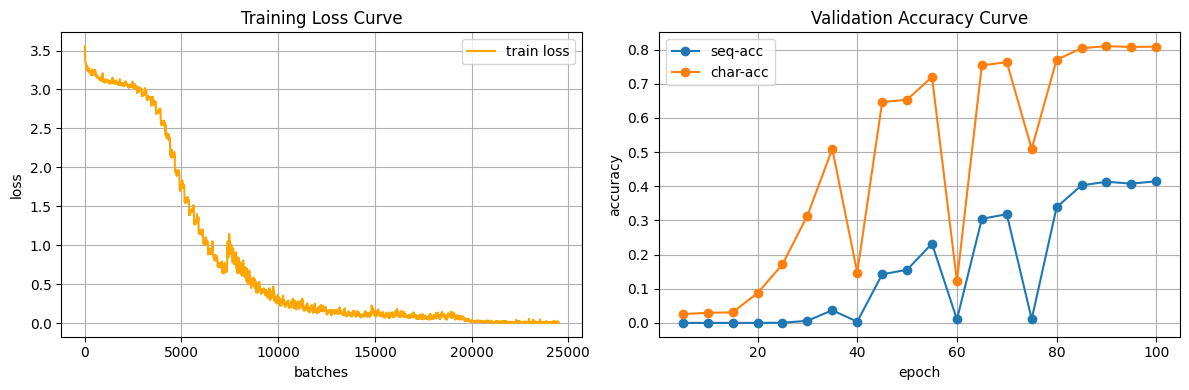

GT: 002e23      PRED: 002e23
GT: 03yl9s      PRED: 03yi9s
GT: 03yuav5     PRED: o3yuqv5
GT: 03zl9o      PRED: 03z19q
GT: 04zqohgi    PRED: 042q0h9i


In [16]:
# ============================================================
# loss function
# ============================================================
plot_losses, plot_batches = [], []
plot_seqacc, plot_characc, plot_epochs = [], [], []
total_batches = 0
best_char_acc = 0.0
print(f"Start training on {len(train_ds)} images ...")
# ============================================================
# Main loop
# ============================================================
for epoch in range(NUM_EPOCHS):
    # 1) teacher forcing
    if epoch < 30:
        teacher_forcing_ratio = 1.0
    elif epoch < 60:
        teacher_forcing_ratio = 0.7
    elif epoch < 80:
        teacher_forcing_ratio = 0.5
    else:
        optimizer.param_groups[1]["lr"] = 3e-4   # decoder
        optimizer.param_groups[0]["lr"] = 1e-4   # encoder
        teacher_forcing_ratio = 0.3

    # 2) 冻不冻 backbone
    freeze_backbone = (epoch < 2)
    if freeze_backbone:
        model.encoder.backbone.eval()
    else:
        model.encoder.backbone.train()
    for p in model.encoder.backbone.parameters():
        p.requires_grad = not freeze_backbone

    if epoch == 10:
        optimizer.param_groups[0]["lr"] = 3e-4   # encoder
        print("↑ bump enc lr to 3e-4 at epoch 10")
    
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0

    pbar = tqdm(
        enumerate(train_dl),
        total=len(train_dl),
        desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (lr_enc={optimizer.param_groups[0]['lr']:.1e}, lr_dec={optimizer.param_groups[1]['lr']:.1e}, tf={teacher_forcing_ratio:.2f})"
    )

    for i, (images_batch, labels_batch, _, _) in pbar:
        images_gpu = images_batch.to(device)
        labels_gpu = labels_batch.to(device)

        logits = model(images_gpu, labels_gpu, teacher_forcing_ratio=teacher_forcing_ratio)
        loss = calculate_loss(logits, labels_gpu, criterion)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        total_batches += 1

        if (i + 1) % 10 == 0:
            avg_loss = running_loss / 10
            pbar.set_postfix(loss=avg_loss)
            plot_losses.append(avg_loss)
            plot_batches.append(total_batches)
            running_loss = 0.0

    avg_epoch_loss = epoch_loss / len(train_dl)
    print(f"--- Epoch {epoch+1} done, avg loss: {avg_epoch_loss:.4f}, backbone training: {not freeze_backbone} ---")

    # 每5轮评估一次
    if (epoch + 1) % 5 == 0 and "test_dl" in globals():
        model.eval()
        total = 0
        correct = 0
        char_accs = []

        with torch.no_grad():
            for images_batch, _, texts_batch, _ in test_dl:
                images_batch = images_batch.to(device)
                _, pred_texts = predict_batch_beam_search(
                    model,
                    images_batch,
                    beam_width=1,  # greedy
                    max_len=50
                )

                for gt, pr in zip(texts_batch, pred_texts):
                    gt, pr = gt.strip().lower(), pr.strip().lower()
                    total += 1
                    if gt == pr:
                        correct += 1
                    L = max(len(gt), len(pr))
                    if L > 0:
                        same = sum(1 for a, b in zip(gt, pr) if a == b)
                        char_accs.append(same / L)

        seq_acc = correct / total if total > 0 else 0
        char_acc = sum(char_accs) / len(char_accs) if char_accs else 0

        plot_epochs.append(epoch + 1)
        plot_seqacc.append(seq_acc)
        plot_characc.append(char_acc)

        print(f" Eval after epoch {epoch+1}: seq-acc={seq_acc:.4f}, char-acc={char_acc:.4f}")
        if char_acc > best_char_acc:
            best_char_acc = char_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f" New best saved: seq-acc={seq_acc:.4f}, char-acc={best_char_acc:.4f}")

# ============================================================
# loss curve
# ============================================================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(plot_batches, plot_losses, label="train loss", color="orange")
plt.xlabel("batches")
plt.ylabel("loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(plot_epochs, plot_seqacc, "-o", label="seq-acc")
plt.plot(plot_epochs, plot_characc, "-o", label="char-acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Validation Accuracy Curve")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

model.eval()
imgs, lbls, texts, _ = next(iter(test_dl))
imgs = imgs.to(device)

with torch.no_grad():
    logits = model(imgs, None, teacher_forcing_ratio=0.0)
preds = logits.argmax(dim=2).cpu().tolist()

for i in range(5):
    gt = texts[i]
    pr_ids = preds[i]
    pr = []
    for id_ in pr_ids:
        if id_ == EOS_TOKEN:
            break
        if id_ < len(id2ch):
            ch = id2ch[id_]
            if ch not in ("<pad>", "<sos>", "<eos>"):
                pr.append(ch)
    pr = "".join(pr)
    print(f"GT: {gt:10s}  PRED: {pr}")

## 8. Test set prepare

In [17]:
test_labels = {}
for p in test_img_files:
    name = os.path.splitext(os.path.basename(p))[0]
    label_name = name.split('-')[0]
    test_labels[label_name] = label_name

if test_img_files:
    test_ds = CaptchaDataset(test_img_files, test_labels, ch2id, h=MODEL_H)
    test_dl = DataLoader(
        test_ds,
        batch_size=64,
        shuffle=False,
        collate_fn=seq2seq_collate_fn,
        num_workers=0,
    )
    print("Test DataLoader ready.")
else:
    print("No test images found.")


Test DataLoader ready.


## 10. Evaluation

In [ ]:
EVAL_MODEL_PATH = "best_model.pth"
BEAM_WIDTH = 5
MAX_LEN = 50

# 1. Construct model
model = ResnetLSTMSeq2Seq(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    encoder_hidden=ENCODER_HIDDEN,
    decoder_hidden=DECODER_HIDDEN,
    attn_dim=ATTN_DIM,
    sos_token_id=SOS_TOKEN,
    device=device,
).to(device)

# 2. Loading weight
ckpt = torch.load(EVAL_MODEL_PATH, map_location=device)
if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
    state = ckpt["model_state_dict"]
else:
    state = ckpt
model.load_state_dict(state, strict=True)
model.eval()
print(f"Loaded model from {EVAL_MODEL_PATH}")

total = 0
correct = 0
char_accs = []
wrong = []

with torch.no_grad():
    for images_batch, labels_batch, texts_batch, paths_batch in tqdm(test_dl, desc="Evaluating"):
        _, pred_texts = predict_batch_beam_search(
            model,
            images_batch,
            beam_width=BEAM_WIDTH,
            max_len=MAX_LEN,
        )

        for true_text, pred_text, path in zip(texts_batch, pred_texts, paths_batch):
            total += 1

            tt = true_text.strip()
            pp = pred_text.strip()
            if tt.lower() == pp.lower():
                correct += 1
            else:
                if len(wrong) < 15:
                    wrong.append((os.path.basename(path), tt, pp))

            if len(tt) > 0:
                L = max(len(tt), len(pp))
                same = sum(1 for a, b in zip(tt, pp) if a == b)
                char_accs.append(same / L)

# 3.Print
if total > 0:
    seq_acc = correct / total
    char_acc = sum(char_accs) / len(char_accs) if char_accs else 0.0
    print(f"\nTotal: {total}, Correct: {correct}, Seq-acc: {seq_acc:.4f} ({seq_acc*100:.2f}%)")
    print(f"Avg char-level accuracy: {char_acc:.4f} ({char_acc*100:.2f}%)")

    if wrong:
        print("\n--- Some wrong examples ---")
        for fn, gt, pr in wrong:
            print(f"  File: {fn}, True: '{gt}', Pred: '{pr}'")


Loaded model from best_model.pth


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]